# Setup

In [1]:
# import your standard packages
%run ../../global_tools/start.py

# import your local functions
from local_functions import *

# make sure the figures plot inline rather than at the end
%matplotlib inline

Default libraries loaded.


# Get Data

In [2]:
ds_WOA = xr.open_dataset('../data/woa_processed.nc')
ds_WOA

<xarray.Dataset>
Dimensions:                      (coastal_loc: 1925, coastal_pos: 439, depth: 57, lat: 35, lon: 55, lonmin,lonmax,latmin,latmax: 4, month: 12)
Coordinates:
  * month                        (month) int64 1 2 3 4 5 6 7 8 9 10 11 12
  * depth                        (depth) float32 0.0 5.0 10.0 ... 1450.0 1500.0
  * lon                          (lon) float32 48.5 49.5 50.5 ... 101.5 102.5
  * lat                          (lat) float32 -1.5 -0.5 0.5 ... 30.5 31.5 32.5
  * coastal_loc                  (coastal_loc) int64 0 1 2 3 ... 1922 1923 1924
  * coastal_pos                  (coastal_pos) int64 0 1 2 3 ... 435 436 437 438
  * lonmin,lonmax,latmin,latmax  (lonmin,lonmax,latmin,latmax) int64 0 1 2 3
Data variables:
    temp                         (month, depth, lat, lon) float64 ...
    psal                         (month, depth, lat, lon) float64 ...
    doxy                         (month, depth, lat, lon) float64 ...
    nitrate                      (month, depth, lat

In [3]:
# ds_CD= xr.open_dataset('../data/CD/woa_cp.nc')

In [4]:
ds_SLA = xr.open_dataset('../data/sla_processed.nc')
ds_SLA

<xarray.Dataset>
Dimensions:           (day_time: 10013, lat: 138, loc_list: 7, lon: 216, month: 12, no_stations: 574, time: 329)
Coordinates:
  * lon               (lon) float64 48.62 48.88 49.12 ... 101.9 102.1 102.4
  * lat               (lat) float64 -1.375 -1.125 -0.875 ... 32.38 32.62 32.88
  * time              (time) datetime64[ns] 1993-01-01 1993-02-01 ... 2020-05-01
  * day_time          (day_time) datetime64[ns] 1993-01-01 ... 2020-05-31
  * month             (month) int64 1 2 3 4 5 6 7 8 9 10 11 12
  * no_stations       (no_stations) float64 1.0 2.0 3.0 ... 572.0 573.0 574.0
  * loc_list          (loc_list) int64 0 80 201 291 382 491 573
Data variables:
    daily_sla         (day_time, lat, lon) float64 ...
    mon_sla           (time, lat, lon) float64 ...
    mon_sla_mon_clim  (month, lat, lon) float64 ...
    mon_sla_mon_anom  (time, lat, lon) float64 ...
    sta_loninds       (no_stations) int64 ...
    sta_latinds       (no_stations) int64 ...
    sta_lon           (no

# Seasonal Anomalies

In [5]:
xx,yy = np.meshgrid(np.array(ds_WOA.lon),np.array(ds_WOA.lat))

mask = mask_coast(xx.flatten(),yy.flatten(),[35,120,-20,30])
mask.shape

(1925,)

In [6]:
var = ds_WOA.doxy_50_200
var_anom = ds_WOA.doxy_50_200_anom
ann_mean = ds_WOA.doxy_50_200_ann_mean

#######################################################
# get seasonal anomaly
# 0 = MAM, 1 = JJA, 2 = SON, 3 = DJF
seasonal_anom = np.full([2,len(ds_WOA.lat),len(ds_WOA.lon)],np.nan)
seasonal_mean = np.full([2,len(ds_WOA.lat),len(ds_WOA.lon)],np.nan)
seasonal_OCP = np.full([2,len(ds_WOA.lat),len(ds_WOA.lon)],np.nan)
seasonal_TCP = np.full([2,len(ds_WOA.lat),len(ds_WOA.lon)],np.nan)
seasonal_TCP_20 = np.full([2,len(ds_WOA.lat),len(ds_WOA.lon)],np.nan)

for ss in range(2):
    if ss == 0:
        ind = [5,6,7,8,9,10] # Summer/Fall - -1 for index
        seasonal_mean[ss,:,:] = np.nanmean(var[ind,:,:],0)
        seasonal_anom[ss,:,:] = np.nanmean(var_anom[ind,:,:],0)
#         seasonal_OCP[ss,:,:] = np.nanmean(ds_CD.OCP[ind,:,:],0)
#         seasonal_TCP[ss,:,:] = np.nanmean(ds_CD.TCP[ind,:,:],0)
#         seasonal_TCP_20[ss,:,:] = np.nanmean(ds_CD.TCP_thresh_20[ind,:,:],0)
        
    elif ss == 1:
        ind = [0,1,2,3,4,11] # Winter/Spring
        seasonal_mean[ss,:,:] = np.nanmean(var[ind,:,:],0)
        seasonal_anom[ss,:,:] = np.nanmean(var_anom[ind,:,:],0)
#         seasonal_OCP[ss,:,:] = np.nanmean(ds_CD.OCP[ind,:,:],0)
#         seasonal_TCP[ss,:,:] = np.nanmean(ds_CD.TCP[ind,:,:],0)
#         seasonal_TCP_20[ss,:,:] = np.nanmean(ds_CD.TCP_thresh_20[ind,:,:],0)
        

#______________________________________________________
# month of lowest oxygen, value of lowest oxygen in shelf waters
#______________________________________________________
mons = np.arange(1,13)

min_mean = np.full([len(ds_WOA.lat),len(ds_WOA.lon)],np.nan)
min_mean_mon = np.full([len(ds_WOA.lat),len(ds_WOA.lon)],np.nan)
min_mean_seas = np.full([len(ds_WOA.lat),len(ds_WOA.lon)],np.nan)

for ii,jj in itertools.product(np.arange(len(ds_WOA.lat)),np.arange(len(ds_WOA.lon))):
    doxy = var[:,ii,jj]
    
    if np.sum(doxy[np.isfinite(doxy)])>0:
        
        ind = np.nanargmin(doxy)

        min_mean[ii,jj] = doxy[ind]
        
        # shift this one so that you can plot dec first
        if mons[ind] == 12:
            min_mean_mon[ii,jj] = 1
        else:
            min_mean_mon[ii,jj] = mons[ind]+1
        
        if (mons[ind] >2) & (mons[ind] <6):
            min_mean_seas[ii,jj] = 1
        elif (mons[ind] >5) & (mons[ind] <9):
            min_mean_seas[ii,jj] = 2
        elif (mons[ind] >8) & (mons[ind] <12):
            min_mean_seas[ii,jj] = 3
        else:
            min_mean_seas[ii,jj] = 4
            
        if (mons[ind] >5) & (mons[ind] <12):
            min_mean_seas[ii,jj] = 1
        elif (mons[ind] ==12) | ((mons[ind] >0) & (mons[ind] <6)):
            min_mean_seas[ii,jj] = 2
            
        if len(doxy[doxy == np.nanmin(doxy)])>1:
                print('Duplicate Values in Minimum.')



/home/jennap/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: Mean of empty slice
/home/jennap/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: RuntimeWarning: Mean of empty slice
/home/jennap/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: RuntimeWarning: Mean of empty slice
/home/jennap/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: Mean of empty slice


In [7]:
# SLA

var_anom = ds_SLA.mon_sla_mon_clim

#######################################################
# get seasonal anomaly
# 0 = MAM, 1 = JJA, 2 = SON, 3 = DJF
seasonal_anom_sla = np.full([2,len(ds_SLA.lat),len(ds_SLA.lon)],np.nan)
for ss in range(2):
    if ss == 0:
        ind = [5,6,7,8,9,10] # Summer/Fall - -1 for index
        seasonal_anom_sla[ss,:,:] = np.nanmean(var_anom[ind,:,:],0)
        
    elif ss == 1:
        ind = [0,1,2,3,4,11] # Winter/Spring
        seasonal_anom_sla[ss,:,:] = np.nanmean(var_anom[ind,:,:],0)

/home/jennap/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: Mean of empty slice
  if sys.path[0] == '':
/home/jennap/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: Mean of empty slice
  app.launch_new_instance()


/home/jennap/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in greater
  """


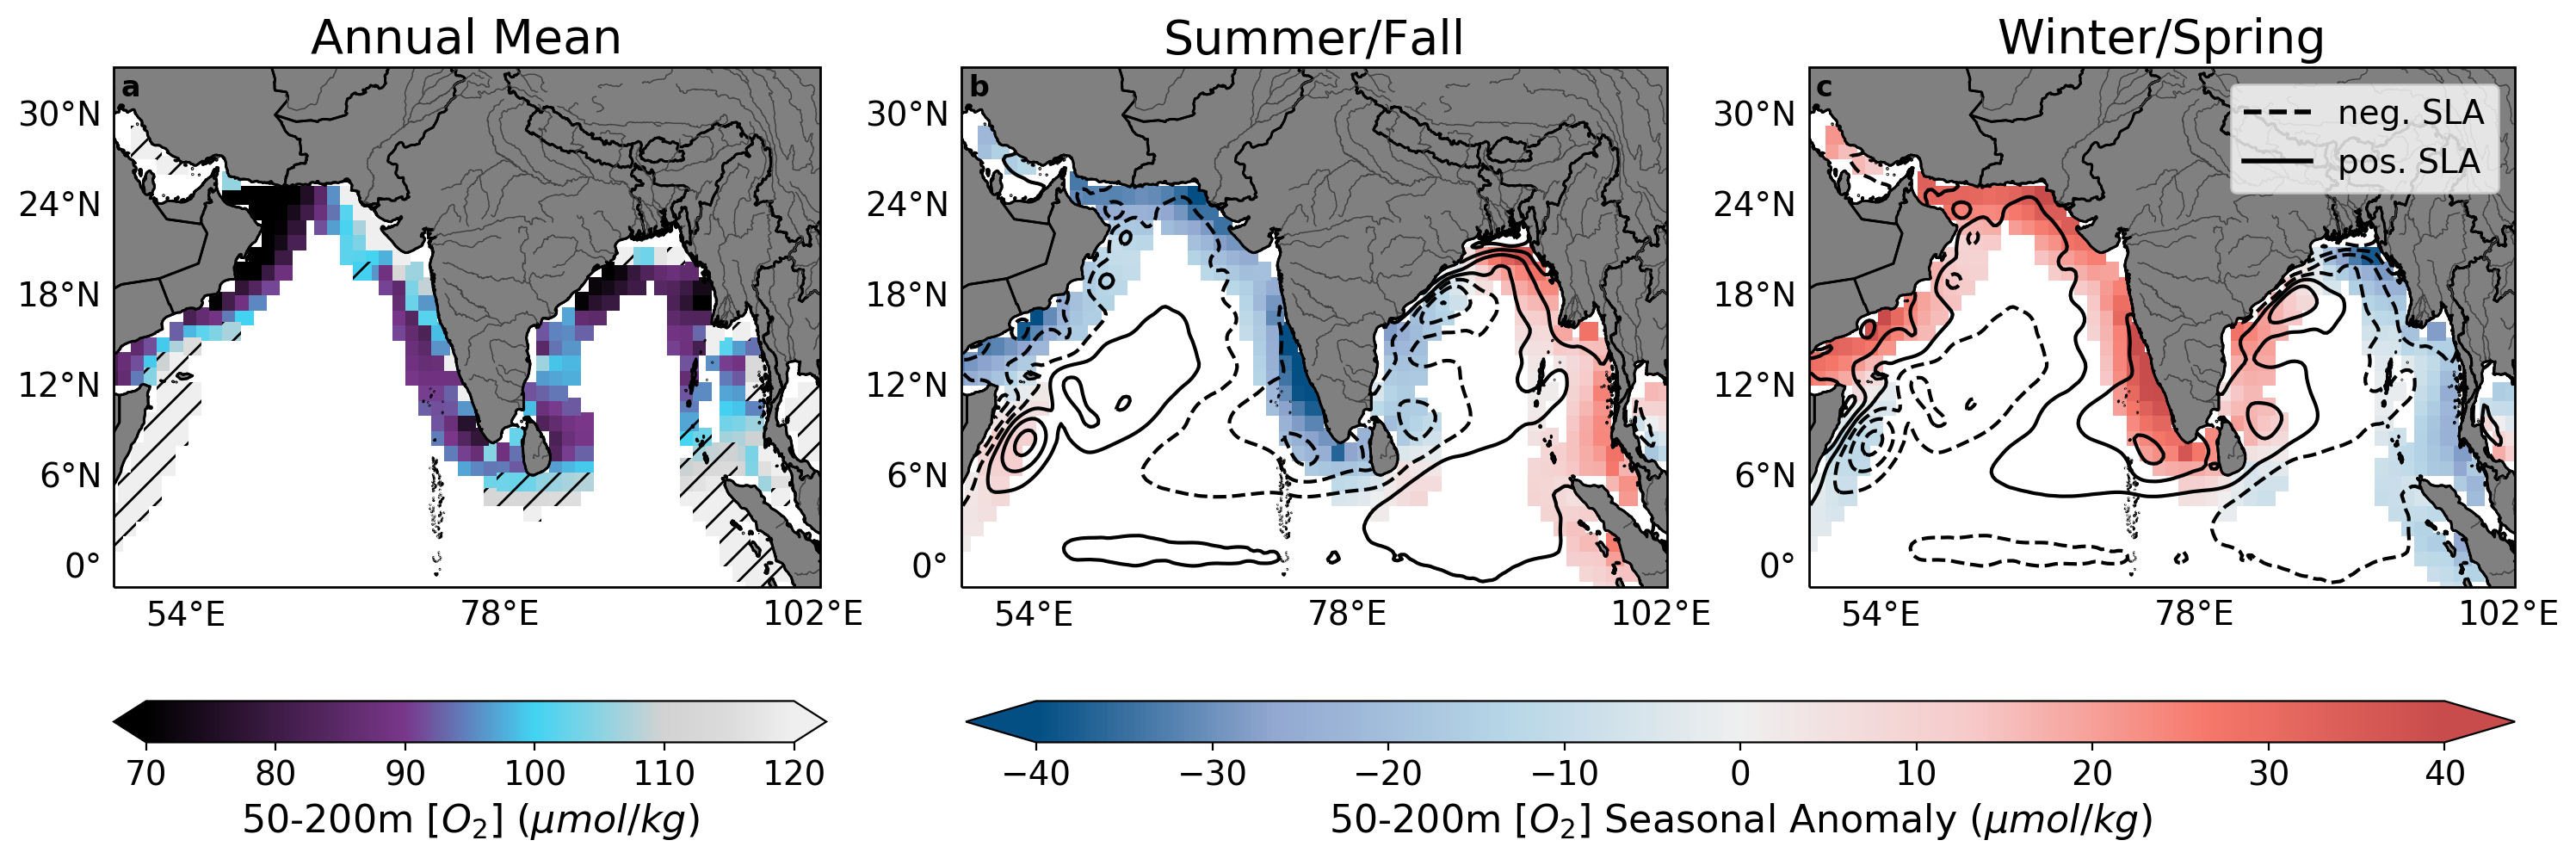

In [12]:
var = seasonal_anom
ann_mean = np.array(ann_mean)
hatch_var = min_mean.flatten()[mask]

hatch_mask = hatch_var > 63

fig = plt.figure(figsize=(18,4),dpi=200)
sz = 60
cmin = 70
cmax = 120

cmin_anom = -40
cmax_anom = 40

# ['#d5f4e6','#80ced6','#fefbd8','#618685']

# cmap = get_continuous_cmap(['#622569','#80ced6','#feb236','#588c7e'],
#                            [0,0.4,0.55, 1])
# cmap = get_continuous_cmap(['#622569','#42d4f4','#ffe119','#f58231','#c94c4c'],
#                            [0,0.4,0.55,0.85, 1])
# cmap = get_continuous_cmap(['#000000','#dcbeff','#000075','#feb236','#3cb44b'],
#                            [0,0.4,0.6,0.8, 1])
# cmap = get_continuous_cmap(['#622569','#42d4f4','#ffe119','#A0A0A0','#D3D3D3'],
#                            [0,0.4,0.55,0.85, 1])
cmap = get_continuous_cmap(['#000000','#7A378B','#42d4f4','#D3D3D3','#DcDcDc','#F0F0F0'],
                           [0,0.4,0.6,0.8,0.9,1])

# navy = '#000075'
# green = '#3cb44b'
# purple = '#622569'
# orange = '#feb236'
# cmap = get_continuous_cmap([green,orange,navy],
#                            [0,0.5,1])
cmap.set_under('k')
# cmap.set_over('darkgreen')
cmap_anom = get_continuous_cmap(['#034f84','#92a8d1','#b7d7e8','#f0f0f0','#f7cac9','#f7786b','#c94c4c'])
# cmap_anom = plt.cm.Blues
xx,yy = np.meshgrid(ds_WOA.lon,ds_WOA.lat)
xx = xx.flatten()[mask]
yy = yy.flatten()[mask]

params = {'legend.fontsize': 14,
         'axes.labelsize': 16,
         'axes.titlesize': 20,
         'xtick.labelsize':14,
         'ytick.labelsize':14}
pylab.rcParams.update(params)

season_title = ['Annual Mean', 'Summer/Fall', 'Winter/Spring']

levels = np.linspace(-0.15,0.15,10)

cbounds = [45,100,0,30]

##############################################################

ax = fig.add_subplot(131,projection= ccrs.PlateCarree())
tmp = ann_mean
tmp = tmp.flatten()[mask]
pann = ax.scatter(xx,yy,c = tmp,marker='s',s= sz,linewidth=0,
                      cmap=cmap,vmin=cmin,vmax=cmax,transform=ccrs.PlateCarree())
ax.scatter(xx[hatch_mask],yy[hatch_mask],c = tmp[hatch_mask],marker='s',s= sz,hatch = '//',linewidth=0,
                      cmap=cmap,vmin=cmin,vmax=cmax,transform=ccrs.PlateCarree())
ax.set_title(season_title[0])
g = add_land(ax, countries = True, rivers = True)
g.xlocator = mticker.FixedLocator([54,78,102])
g.xlabel_style = {'size': 14}
g.ylabel_style = {'size': 14}
add_letter(ax, 'a')

ax = fig.add_subplot(132,projection= ccrs.PlateCarree())
tmp = var[0,:,:]
tmp = tmp.flatten()[mask]
p = ax.scatter(xx,yy,c = tmp,marker='s',s= sz,linewidth=0,
                      cmap=cmap_anom,vmin=cmin_anom,vmax=cmax_anom,transform=ccrs.PlateCarree())
c=ax.contour(ds_SLA.lon,ds_SLA.lat,seasonal_anom_sla[0,:,:], colors = 'black',
          levels = levels)
# ax.clabel(c, c.levels, inline=True, fontsize=10)
ax.set_title(season_title[1])
g = add_land(ax, countries = True, rivers = True)
g.xlocator = mticker.FixedLocator([54,78,102])
g.xlabel_style = {'size': 14}
g.ylabel_style = {'size': 14}
add_letter(ax, 'b')

ax = fig.add_subplot(133,projection= ccrs.PlateCarree())

tmp = var[1,:,:]
tmp = tmp.flatten()[mask]
p = ax.scatter(xx,yy,c = tmp,marker='s',s= sz,linewidth=0,
                      cmap=cmap_anom,vmin=cmin_anom,vmax=cmax_anom,transform=ccrs.PlateCarree())
c=ax.contour(ds_SLA.lon,ds_SLA.lat,seasonal_anom_sla[1,:,:], colors = 'black',
          levels = levels)
# ax.clabel(c, c.levels, inline=True, fontsize=10)
g = add_land(ax, countries = True, rivers = True)
g.xlocator = mticker.FixedLocator([54,78,102])
g.xlabel_style = {'size': 14}
g.ylabel_style = {'size': 14}
add_letter(ax, 'c')

ax.set_title(season_title[2])

neg = plt.Line2D((0, 1), (0, 0), color='k', linestyle='--', linewidth=2)
pos = plt.Line2D((0, 1), (0, 0), color='k', linestyle='-', linewidth=2)

l = plt.legend([neg,pos],['neg. SLA', 'pos. SLA'],facecolor = 'w')
# plt.setp(l.get_texts(), color='w');

cbar_ax = fig.add_axes([0.4, -0.1, 0.5, 0.06])
cbar_anom = fig.colorbar(p,cax=cbar_ax, pad=0.04, orientation = 'horizontal', extend = 'both')
cbar_anom.set_label('50-200m [$O_2$] Seasonal Anomaly ($\mu mol/ kg$)', fontsize = 16)

cbar_ax = fig.add_axes([0.125, -0.1, 0.23, 0.06])
cbar = fig.colorbar(pann,cax=cbar_ax, pad=0.04, orientation = 'horizontal', extend = 'both')
cbar.set_label('50-200m [$O_2$] ($\mu mol/ kg$)', fontsize = 16)


In [9]:
# var = seasonal_anom
# ann_mean = np.array(ann_mean)

# fig, axes = plt.subplots(nrows = 1, ncols = 2,figsize=(14,3.5),dpi=200,subplot_kw={'projection': ccrs.PlateCarree()})
# sz = 60
# cmin = 70
# cmax = 120

# cmap.set_under('k')
# # cmap.set_over('darkgreen')
# cmap_anom = get_continuous_cmap(['#034f84','#92a8d1','#b7d7e8','#f0f0f0','#f7cac9','#f7786b','#c94c4c'])
# # cmap_anom = plt.cm.Blues
# xx,yy = np.meshgrid(ds_CD.lon,ds_CD.lat)
# xx = xx.flatten()
# yy = yy.flatten()

# plt.rcParams.update({'font.size': 14})
# season_title = ['Annual Mean', 'Summer/Fall', 'Winter/Spring']

# levels = np.linspace(-0.15,0.15,10)

# cbounds = [45,100,0,30]

# ##############################################################

# ax = axes[0]
# tmp = var[0,:,:]
# tmp = tmp.flatten()
# p = ax.scatter(xx[mask],yy[mask],c = tmp[mask],marker='s',s= sz,
#                       cmap=cmap_anom,vmin=cmin_anom,vmax=cmax_anom,transform=ccrs.PlateCarree())
# c=ax.contour(ds_SLA.lon,ds_SLA.lat,seasonal_anom_sla[0,:,:], colors = 'black',
#           levels = levels)
# # ax.clabel(c, c.levels, inline=True, fontsize=10)
# ax.set_title(season_title[1])
# add_land(ax, cbounds)
# add_letter(ax, 'a', x = 0.01, y = .93)

# ax = axes[1]

# tmp = var[1,:,:]
# tmp = tmp.flatten()
# p = ax.scatter(xx[mask],yy[mask],c = tmp[mask],marker='s',s= sz,
#                       cmap=cmap_anom,vmin=cmin_anom,vmax=cmax_anom,transform=ccrs.PlateCarree())
# c=ax.contour(ds_SLA.lon,ds_SLA.lat,seasonal_anom_sla[1,:,:], colors = 'black',
#           levels = levels)
# # ax.clabel(c, c.levels, inline=True, fontsize=10)
# add_land(ax, cbounds)
# add_letter(ax, 'b', x = 0.01, y = .93)

# ax.set_title(season_title[2])

# neg = plt.Line2D((0, 1), (0, 0), color='k', linestyle='--', linewidth=2)
# pos = plt.Line2D((0, 1), (0, 0), color='k', linestyle='-', linewidth=2)

# l = plt.legend([neg,pos],['upwelling', 'downwelling'],facecolor = 'w')
# # plt.setp(l.get_texts(), color='w');

# cbar_ax = fig.add_axes([0.13, -0.1, 0.75, 0.07])
# cbar_anom = fig.colorbar(p,cax=cbar_ax, pad=0.04, orientation = 'horizontal', extend = 'both')
# cbar_anom.set_label('50-200dbar [$O_2$] Seasonal Anomaly ($\mu mol/ kg$)')



In [11]:
# var1 = min_mean
# var2 = min_mean_mon
# fig, axes = plt.subplots(nrows = 1, ncols = 2,figsize=(16,6),dpi=200,subplot_kw={'projection': ccrs.PlateCarree()})
# sz = 60

# cmin1 = 0
# cmax1 = 100

# cmin2 = 1
# cmax2 = 12

# cmap1 = get_continuous_cmap(['#622569','#622569','#b8a9c9','#588c7e'],
#                            [0,0.59,0.65, 1])
# cmap2 = get_continuous_cmap(['#034f84','#92a8d1','#b7d7e8','#f0f0f0','#f7cac9','#f7786b','#c94c4c'])

# cbounds = [45,100,0,30]


# xx,yy = np.meshgrid(ds_CD.lon,ds_CD.lat)
# xx = xx.flatten()
# yy = yy.flatten()

# # plt.rcParams.update({'legend.fontsize': 16,
# #                      'legend.handlelength': 2,
# #                      "legend.markerscale":2,
# #                      'font.size': 12})

# title = ['Minimum','Month of Minimum']
# mon_title = ['dec','jan','feb','mar','apr','may','jun','july','aug','sep','oct','nov']
# ##############################################################

# ax = axes[0]
# tmp = var1.flatten()
# p = ax.scatter(xx[mask],yy[mask],c = tmp[mask],marker='s',s= sz,
#                cmap=cmap1,vmin=cmin1,vmax=cmax1,transform=ccrs.PlateCarree())
# ax.set_title(title[0])
# add_land(ax, cbounds)
# add_letter(ax, 'a', x = 0.01, y = .93)

# cbar = plt.colorbar(p, ax = ax,orientation='horizontal', extend= 'max',
#                    ticks = np.arange(0,120,20))
# cbar.set_ticklabels(['0','20','40', 'hypoxia', '80','100'])
# cbar.set_label('50-200dbar [$O_2$] ($\mu mol/ kg$)')

# ax = axes[1]
# tmp = var2.flatten()

# p = ax.scatter(xx[mask],yy[mask],c = tmp[mask],marker='s',s= sz,
#                cmap=cmap2,vmin=cmin2,vmax=cmax2,transform=ccrs.PlateCarree())
    
# cbar2 = plt.colorbar(p, ax = ax,orientation='horizontal', extend= 'both',
#                     ticks = np.arange(1,13))
# cbar2.set_ticklabels(mon_title)
# add_land(ax, cbounds)
# ax.set_title(title[1])
# add_letter(ax, 'b', x = 0.01, y = .925)